In [115]:
import pickle
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

In [312]:
#date_format = date.today().strftime("%Y_%m_%d")
date_format = '2023_08_31'
root_path = f'C:/Users/Blackr/Documents/CCUS/MAPs/Initiate/{date_format}/'
experiment_name = 'rbnb3p105'
test = 'Test_2'

In [428]:
'''
Developed by Robert Black:
The following code is used to curate and process the data for the CCUS MAP. In particular, this post-processing algorithm
is for the WGC project.

This is split into two parts - the first part is curation of the data from electrochem excel files to the global project pickle file

The second part is to curate the data into 'metric' data that will be used for the optimization and/or process the data into
useful pieces

This has a very specific format and is outfitted to our CCUS MAP data outputs. 

File names are required to take on the form: Test_{i}_ch{j}_CA_3.csv, as an example
{i} = Test number
{j} = ch1. is for deposition, ch2. is for characterization, ch3. is for performance evaluation

#TODO Improvements - how to avoid loading/unloading the pickle file everytime? Will become a slow down when the file gets large
'''

class PostProcessing:
    def __init__(self,root_path,experiment_name,test): # add in the rootpath here
	# Have the class initialization create and load the .json file as a dictionary?
            self.root_path = root_path
            self.experiment_name = experiment_name
            self.test = test
    
    def curate_deposition(self): 
        global loaded_data # Want to have the variable outside of the function
        
        # import in the empty pickle file that already exists
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'rb') as file:
            loaded_data = pickle.load(file)

        # Import each excel file and put all the data into the dictionary
        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_OCV_1.csv', header = 14) #REPLACE WITH ACTUAL TEST NAME

        ocv_data = {}
        for column in df.columns:
            ocv_data[column] = df[column].to_list()
            loaded_data[f'{self.experiment_name}'][f'{self.test}']['Depo']['OCV'] = ocv_data
        
        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_PEIS_2.csv', header = 29) #REPLACE WITH ACTUAL TEST NAME

        peis_data = {}
        for column in df.columns:
            peis_data[column] = df[column].to_list()
            loaded_data[f'{self.experiment_name}'][f'{self.test}']['Depo']['PEIS'] = peis_data

        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_CA_3.csv', header = 19) #REPLACE WITH ACTUAL TEST NAME

        ca_data = {}
        for column in df.columns:
            ca_data[column] = df[column].to_list()
            loaded_data[f'{self.experiment_name}'][f'{self.test}']['Depo']['CA'] = ca_data
       
        # Save the pickle file
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data

    def curate_characterization(self):
        global loaded_data # Want to have the variable outside of the function
        # import in the empty pickle file that already exists
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'rb') as file:
            loaded_data = pickle.load(file)

        # Import each excel file and put all the data into the dictionary
        df = pd.read_csv(f'{self.root_path}{self.test}_ch2_OCV_1.csv', header = 14) #REPLACE WITH ACTUAL TEST NAME

        ocv_data = {}
        for column in df.columns:
            ocv_data[column] = df[column].to_list()
            loaded_data[f'{self.experiment_name}'][f'{self.test}']['Depo']['OCV'] = ocv_data

        # Curate the PEIS data
        for i in [2,10]:
            df = pd.read_csv(f'{self.root_path}{self.test}_ch2_PEIS_{i}.csv', header = 29) #REPLACE WITH ACTUAL TEST NAME
            peis_data = {}
            for column in df.columns:
                peis_data[column] = df[column].to_list()
                loaded_data[f'{self.experiment_name}'][f'{self.test}']['Char'][f'PEIS_{i}'] = peis_data

        # Curate the CV data
        for i in [3,4,5,6,7,8,9]:
            df = pd.read_csv(f'{self.root_path}{self.test}_ch2_CV_{i}.csv', header = 22) #REPLACE WITH ACTUAL TEST NAME
            cv_data = {}
            for column in df.columns:
                cv_data[column] = df[column].to_list()
                loaded_data[f'{self.experiment_name}'][f'{self.test}']['Char'][f'CV_{i}'] = cv_data
       
        # Save the pickle file
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data
    
     #def curate_performance(self):
    
    def determine_mass_loading(self, truncate_time):
        global loaded_data
        
        # Entire deposition
        x_all = loaded_data[f'{experiment_name}'][f'{self.test}']['Depo']['CA']['t(s)']
        y_all = np.abs(loaded_data[f'{experiment_name}'][f'{self.test}']['Depo']['CA']['I(A)'])
        area_all = np.trapz(y_all, x_all)
        print(f'Mass Loading All = {area_all}')

        # Time truncated deposition
        filter = np.where(np.array(loaded_data[f'{experiment_name}'][f'{self.test}']['Depo']['CA']['t(s)']) > truncate_time)
        x_trunc = np.array(loaded_data[f'{experiment_name}'][f'{self.test}']['Depo']['CA']['t(s)'])[filter]
        y_trunc = np.array(np.abs(loaded_data[f'{experiment_name}'][f'{self.test}']['Depo']['CA']['I(A)']))[filter]
        area_trunc = np.trapz(y_trunc, x_trunc)
        print(f'Mass Loading Truncated ({truncate_time} s) = {area_trunc}')

        #plot the data
        plt.plot(x_all,y_all)
        plt.fill_between(x_all, y_all, color='skyblue', alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.axvline(0, color='red', linestyle='--')
        plt.legend()
        plt.ylabel('Current (A)')
        plt.xlabel('Time (s)')
        plt.title(f'Deposition Profile {self.test}')
        plt.savefig(f'{self.root_path}Deposition_{self.test}.jpeg', dpi = 300)
        plt.show()
        
        #Put the data into the data archive
        loaded_data[f'{experiment_name}'][f'{self.test}']['Metric']['Loading'] = {'mass_total':area_all,'mass_trunc':area_trunc,'trunc_time':truncate_time}

        # Save the pickle file
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data
    
    def determine_ESCA(self):
        global loaded_data # Want to have the variable outside of the function
        
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'rb') as file:
            loaded_data = pickle.load(file)
        
        # define the scan_rate and make other dummy variables to be updated
        # scan_rate = np.array([0.025,0.05,0.075,0.100,0.125,.150])
        scan_rate = np.array([0.025,0.05,0.100,0.125,.150])
        ESCA_current_positive = np.zeros(len(scan_rate))
        ESCA_current_negative = np.zeros(len(scan_rate))
        ESCA_current_positive_std = np.zeros(len(scan_rate))
        ESCA_current_negative_std = np.zeros(len(scan_rate))

        #for i,j in enumerate([4,5,6,7,8,9]): # This can be adjusted based no the number of scan_rates used, note did not use the first CV
        for i,j in enumerate([4,5,7,8,9]): # This can be adjusted based no the number of scan_rates used, note did not use the first CV
            Ewe_array = np.array(loaded_data[f'{self.experiment_name}'][f'{self.test}']['Char'][f'CV_{j}']['Ewe(V)'])
            current_array = np.array(loaded_data[f'{self.experiment_name}'][f'{self.test}']['Char'][f'CV_{j}']['I(A)'])
            cycle_array = np.array(loaded_data[f'{self.experiment_name}'][f'{self.test}']['Char'][f'CV_{j}']['Cycle'])

            # Find the indices for where Ewe ~-0.1V, noting the threshold value used to find something 'close enough'
            target_value = -0.1
            threshold = 0.005
            indices = np.where(np.abs(Ewe_array - target_value) <= threshold)[0]

            # if there are indices value this will not be empty
            # grab associated values from the other arrays
            if indices.size > 0:
                current_values = current_array[indices]
                cycle_values = cycle_array[indices]
            else:
                print('error: no Ewe(V) = -0.1 V values were found') #TODO write this as an error

            # Split the values into anodic and cathodic current values
            ESCA_current_positive[i] = np.mean(current_values[current_values > 0]) 
            ESCA_current_negative[i] = np.mean(current_values[current_values < 0]) 
            ESCA_current_positive_std[i] = np.std(current_values[current_values > 0]) 
            ESCA_current_negative_std[i] = np.std(current_values[current_values < 0])
            
            #plot store each iteration as a plot:
            plt.plot(Ewe_array,current_array,label = scan_rate[i])

        #plot the individual cycling data
        plt.legend()
        plt.ylabel('Current (A)')
        plt.xlabel('Ewe (V)')
        plt.title(f'ESCA Individual Cycles {self.test}')
        plt.savefig(f'{self.root_path}ESCA_Cycling_Data_{self.test}.jpeg',dpi = 300)
        plt.show()
        
        #linear fit
        ESCA_positive, intercept_positive = np.polyfit(scan_rate,ESCA_current_positive,1)
        ESCA_negative, intercept_negative = np.polyfit(scan_rate,ESCA_current_negative,1)
        
        #plot the ESCA data
        plt.scatter(scan_rate,ESCA_current_positive,label = 'positive I')
        plt.scatter(scan_rate,ESCA_current_negative,label = 'negative I')
        plt.plot(scan_rate,ESCA_positive*scan_rate + intercept_positive)
        plt.plot(scan_rate,ESCA_negative*scan_rate + intercept_negative)
        plt.xlabel('Scan Rate (V/s)')
        plt.ylabel('Current (A)')
        plt.title(f'ESCA Fit {self.test}')
        plt.savefig(f'{self.root_path}ESCA_{self.test}.jpeg',dpi = 300)
        plt.show()
        
        # Store the values as metric values in the .json file
        loaded_data[f'{self.experiment_name}'][f'{self.test}']['Metric']['ECSA'] = {'scan_rate':scan_rate,'I(A)':[ESCA_current_positive,ESCA_current_negative,ESCA_current_positive_std,ESCA_current_negative_std],'ESCA(F)':{'ESCA_positive':ESCA_positive,'ESCA_negative':ESCA_negative,
                                                                                                                    'intercept_positive':intercept_positive,'intercept_negative':intercept_negative}}
        
        # Save the pickle file
        with open(f'{self.root_path}{self.experiment_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data

In [435]:
process_data = PostProcessing(root_path, experiment_name, test = 'Test_2')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mass Loading All = 0.002185846134677152
Mass Loading Truncated (10 s) = 0.001553810474197372


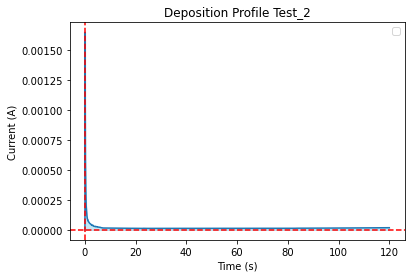

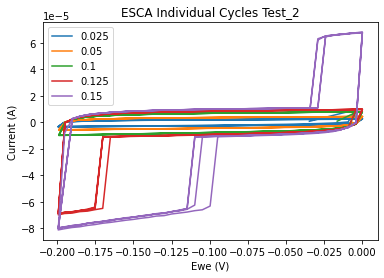

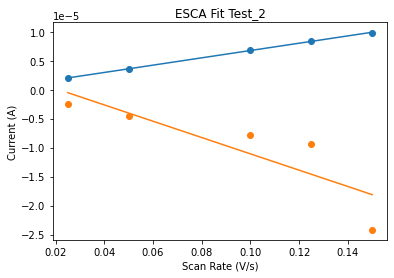

{'rbnb3p105': {'Test_0': {'Depo': {}, 'Char': {}, 'Metric': {}, 'AL': {}},
  'Test_1': {'Depo': {'OCV': {'t(s)': [0.0,
      0.4999999873689376,
      0.9999999747378752,
      1.4999999621068127,
      1.9999999494757503,
      2.499999936844688,
      2.999999924213625,
      3.499999911582563,
      3.9999998989515007,
      4.499999886320438,
      4.999999873689376,
      5.499999861058313,
      5.999999848427251,
      6.499999835796189,
      6.999999823165126,
      7.499999810534064,
      7.999999797903001,
      8.499999785271939,
      8.999999772640876,
      9.499999760009814,
      9.999999747378752,
      10.49999973474769,
      10.999999722116629,
      11.499999709485564,
      11.999999696854502,
      12.49999968422344,
      12.999999671592375,
      13.499999658961316,
      13.999999646330252,
      14.49999963369919,
      14.999999621068127,
      15.499999608437063,
      15.999999595806004,
      16.49999958317494,
      16.999999570543878,
      17.4999995

In [436]:
process_data.curate_deposition()
process_data.determine_mass_loading(truncate_time = 10)
process_data.curate_characterization()
process_data.determine_ESCA()

In [ ]:
with open(f'{root_path}{experiment_name}_saved_data.pkl', 'rb') as file:
    check = pickle.load(file)

In [78]:
with open(f'{root_path}{experiment_name}_saved_data_new.pkl', 'wb') as file:
    pickle.dump(loaded_data, file)

In [434]:
loaded_data[f'{experiment_name}']['Test_1']['Char'].keys()

dict_keys(['PEIS_2', 'PEIS_10', 'CV_3', 'CV_4', 'CV_5', 'CV_6', 'CV_7', 'CV_8', 'CV_9'])

In [ ]:
# Now focus on extracting the metric data from the plots
'''
#TODO
Deposition
- get the mass loading of the Au automatically through curve integration
ECSA
- get the iR, OCV, and surface area from the plots
Performance
- CO2R at certain voltage
'''


# ESCA Playground

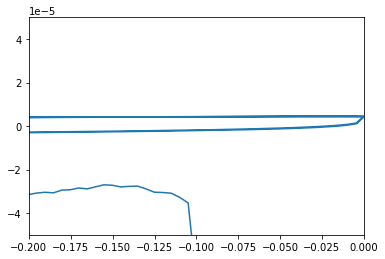

In [109]:
for i in [3]:
    x = loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{i}']['Ewe(V)']
    y = loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{i}']['I(A)']
    plt.plot(x,y)
    plt.ylim(-0.00005,0.00005)
    plt.xlim(-0.2,0)

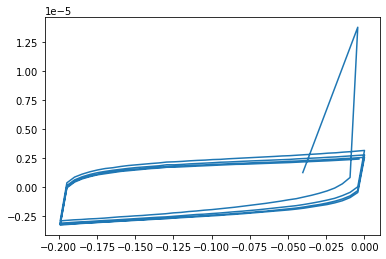

In [190]:
for i in [4]:
    x = loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{i}']['Ewe(V)']
    y = loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{i}']['I(A)']
    plt.plot(x,y)

In [397]:
#def determine_ECSA(scan_rate):

scan_rate = np.array([0.025,0.05,0.075,0.100,0.125,.150])
ESCA_current_positive = np.zeros(len(scan_rate))
ESCA_current_negative = np.zeros(len(scan_rate))
ESCA_current_positive_std = np.zeros(len(scan_rate))
ESCA_current_negative_std = np.zeros(len(scan_rate))

for i,j in enumerate([4,5,6,7,8]):
    example = np.array(loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{j}']['Ewe(V)'])
    current_array = np.array(loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{j}']['I(A)'])
    cycle_array = np.array(loaded_data[f'{experiment_name}']['Test_1']['Char'][f'CV_{j}']['Cycle'])

    # Find the indices for where Ewe ~-0.1V, noting the threshold value used to find something 'close enough'
    target_value = -0.1
    threshold = 0.005
    indices = np.where(np.abs(example - target_value) <= threshold)[0]

    # if there are indices value this will not be empty
    # grab associated values from the other arrays
    if indices.size > 0:
        current_values = current_array[indices]
        cycle_values = cycle_array[indices]
    else:
        print('error: no Ewe(V) = -0.1 V values were found') #TODO write this as an error

    # Split the values into anodic and cathodic current values
    ESCA_current_positive[i] = np.mean(current_values[current_values > 0]) 
    ESCA_current_negative[i] = np.mean(current_values[current_values < 0]) 
    ESCA_current_positive_std[i] = np.std(current_values[current_values > 0]) 
    ESCA_current_negative_std[i] = np.std(current_values[current_values < 0])


#linear fit
ESCA_positive, intercept_positive = np.polyfit(scan_rate,ESCA_current_positive,1)
ESCA_negative, intercept_negative = np.polyfit(scan_rate,ESCA_current_negative,1)
    
# Store the values as metric values in the .json file
loaded_data[f'{experiment_name}']['Test_1']['Metric']['ECSA'] = {'scan_rate':scan_rate,'I(A)':[ESCA_current_positive,ESCA_current_negative,ESCA_current_positive_std,ESCA_current_negative_std],'ESCA(F)':{'ESCA_positive':ESCA_positive,'ESCA_negative':ESCA_negative,
                                                                                                                     'intercept_positive':intercept_positive,'intercept_negative':intercept_negative}}

In [401]:
y = ESCA_positive*scan_rate + intercept_positive
y

array([1.65898252e-05, 1.53170021e-05, 1.40441789e-05, 1.27713557e-05,
       1.14985325e-05, 1.02257093e-05])

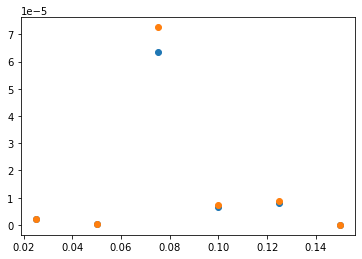

In [398]:
x = loaded_data[f'{experiment_name}']['Test_1']['Metric']['ECSA']['scan_rate']
y = loaded_data[f'{experiment_name}']['Test_1']['Metric']['ECSA']['I(A)'][0]
plt.scatter(x,y)
x = loaded_data[f'{experiment_name}']['Test_1']['Metric']['ECSA']['scan_rate']
y2 = abs(loaded_data[f'{experiment_name}']['Test_1']['Metric']['ECSA']['I(A)'][1])
plt.scatter(x,y2)

In [226]:
loaded_data[f'{experiment_name}']['Test_1']['Depo']['CA'].keys()

dict_keys(['t(s)', 'Ewe(V)', 'I(A)', 'cycle'])

# Deposition Data Playground

In [288]:
def determine_mass_loading(self, truncate_time):
    # Entire deposition
    x_all = loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)']
    y_all = np.abs(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['I(A)'])
    area_all = np.trapz(y_all, x_all)
    print(area_all)
    
    # Time truncated deposition
    filter = np.where(np.array(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)']) > truncate_time)
    x_trunc = np.array(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)'])[filter]
    y_trunc = np.array(np.abs(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['I(A)']))[filter]
    area_trunc = np.trapz(y_trunc, x_trunc)
    
    #plot the data
    plt.plot(x_all,y_all)
    plt.fill_between(x_all, y_all, color='skyblue', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.axvline(0, color='red', linestyle='--')
    plt.legend()
    plt.title(f'Deposition Profile Test_{i}')
    plt.savefig(f'Deposition_Test_{i}.jpeg', dpi = 300)
    plt.show()
    
    
    #Put the data into the data archive
    loaded_data[f'{experiment_name}'][f'Test_{i}']['Metric']['Loading'] = {'mass_total':area_all,'mass_trunc':area_trunc,'trunc_time':truncate_time}

In [290]:
determine_mass_loading(self, truncate_time)

NameError: name 'self' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.00446000432828843


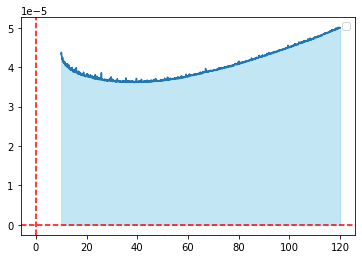

In [253]:
# take a certain value
filter = np.where(np.array(loaded_data[f'{experiment_name}']['Test_1']['Depo']['CA']['t(s)']) > 10)
x = np.array(loaded_data[f'{experiment_name}']['Test_1']['Depo']['CA']['t(s)'])[filter]
y = np.array(np.abs(loaded_data[f'{experiment_name}']['Test_1']['Depo']['CA']['I(A)']))[filter]
plt.plot(x,y)

area = np.trapz(y, x)
print(area)

#plot the data
plt.fill_between(x, y, color='skyblue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.008054485307459332
0.002185846134677152
0.0012303674769711234
0.0013338574737614271
0.014612450858063477


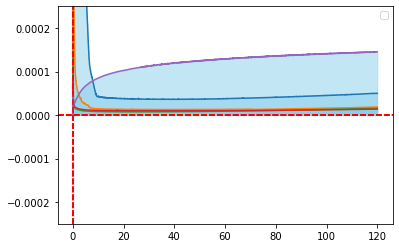

In [283]:
for i in [1,2,3,4,5]: 
    x = loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)']
    y = np.abs(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['I(A)'])
    plt.plot(x,y)

    area = np.trapz(y, x)
    print(area)

    #plot the data
    plt.fill_between(x, y, color='skyblue', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.axvline(0, color='red', linestyle='--')
    plt.legend()
    plt.ylim(-0.00025,0.00025)
    
plt.show()

0.00446000432828843
0.001553810474197372
0.001112829041719344
0.0011963148519392786
0.013987755941786327


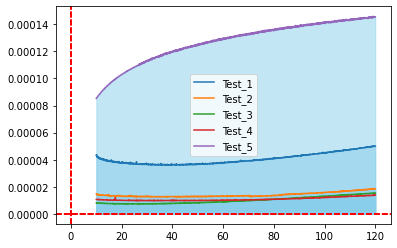

In [287]:
for i in [1,2,3,4,5]: 
    # take a certain value
    filter = np.where(np.array(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)']) > 10)
    x = np.array(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['t(s)'])[filter]
    y = np.array(np.abs(loaded_data[f'{experiment_name}'][f'Test_{i}']['Depo']['CA']['I(A)']))[filter]
    plt.plot(x,y, label = f'Test_{i}')

    area = np.trapz(y, x)
    print(area)

    #plot the data
    plt.fill_between(x, y, color='skyblue', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.axvline(0, color='red', linestyle='--')
    plt.legend()
    
plt.show()